# Make Figure 1

Steps:
1. Read in all Gaia RR Lyrae data (no cleaning, so use for more than a backdrop at your own peril!)
2. Read in Multinest chains for each of the posteriors
3. Overplot the locations on the the RR Lyrae image

In [1]:

# basic imports
from __future__ import print_function
import numpy as np
from numpy.linalg import eig, inv
import time



import scipy.interpolate as interpolate
from scipy.interpolate import UnivariateSpline
import scipy

# ipython reload capabilities for edits to external code
%load_ext autoreload
%autoreload 2



# plotting elements
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.cm as cm
cmap = cm.RdBu_r

import matplotlib as mpl
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['xtick.labelsize'] = 12
mpl.rcParams['ytick.labelsize'] = 12
mpl.rcParams['font.weight'] = 'medium'
mpl.rcParams['axes.linewidth'] = 1.5
mpl.rcParams['xtick.major.width'] = 1.5
mpl.rcParams['xtick.minor.width'] = 0.75
mpl.rcParams['xtick.minor.visible'] = True
mpl.rcParams['ytick.major.width'] = 1.5
mpl.rcParams['ytick.minor.width'] = 0.75
mpl.rcParams['ytick.minor.visible'] = True


# coordinate transformation
import reflexmotion.definecoordinates as coord
import reflexmotion.kde as kde_3d
import reflexmotion.posteriorreader as posteriorreader



## Load up RR Lyrae data

In [2]:
# RR Lyrae from vari_classifier_result: this is too large to pass around, 
# so you'll have to grab your own version. BUT, the instructions to make the calls
# are in the respective cells.
rrlyrae_input_directory = '../Shells/data/'

In [3]:
'''
# get the rr lyrae FROM gaia variable classifier

# this is the AQDL call
SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.best_class_name,variables.best_class_score,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_classifier_result AS variables 
    ON variables.source_id = gaia.source_id


'''

GRRV = np.genfromtxt(rrlyrae_input_directory+'gaia_allvariable.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "best_class_name","best_class_score","teff_val","a_g_val"),\
                             'formats': ('f16','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')





In [4]:
np.unique(GRRV['best_class_name'])

rrls2 = np.where( ((GRRV['best_class_name']==b'ARRD') | 
                   (GRRV['best_class_name']==b'RRAB') |
                   (GRRV['best_class_name']==b'RRC') |
                   (GRRV['best_class_name']==b'RRD')))[0]

print(rrls2.size)

195780


In [5]:
'''

# just from rrlyrae table: specific object study

SELECT gaia.source_id,gaia.ra,gaia.ra_error,gaia.dec,gaia.dec_error,
gaia.parallax,gaia.parallax_error,gaia.pmra,gaia.pmra_error,
gaia.pmdec,gaia.pmdec_error,gaia.phot_g_mean_flux,gaia.phot_g_mean_flux_error,
gaia.phot_g_mean_mag,gaia.phot_bp_mean_flux,gaia.phot_bp_mean_flux_error,
gaia.bp_rp,gaia.radial_velocity,gaia.radial_velocity_error,
variables.metallicity,variables.best_classification,gaia.teff_val,gaia.a_g_val
FROM gaiadr2.gaia_source AS gaia
INNER JOIN gaiadr2.vari_rrlyrae AS variables 
    ON variables.source_id = gaia.source_id

'''

# RR Lyrae from specific object studies (SOS)
GRRL = np.genfromtxt(rrlyrae_input_directory+'varirrlyrae.csv',\
                        dtype={'names': ("gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "metallicity","best_class","teff_val","a_g_val","ebv"),\
                             'formats': ('f16','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','S20','f8','f8','f8')},\
                 skip_header=1,delimiter=',')




In [6]:
rrls1 = np.where(np.isfinite(GRRL['phot_g_mean_flux']))[0]
print(rrls1.size)


140784


In [7]:
#RAJ2000;DEJ2000;GLON;GLAT;gmag;u-g;D0.2;fm;cHg;bHg;d;r;x;y;z;HRV;e_HRV;Vgal;DR8;Sloan;SimbadName


#RAJ2000;DEJ2000;S3ab;S3c;DM;Per;phi0;gAmp;rAmp;iAmp;zAmp;gmag;rmag;imag;zmag;<gmag>;<rmag>;<imag>;
#<zmag>;E(B-V);S10;PS1;Sloan;SimbadName

# note that I did not apply any threshold: so there are noisy RRL in here for sure.

S17 = np.genfromtxt(rrlyrae_input_directory+'Sesar17.txt',\
                        dtype={'names': ("ra","dec","S3ab","S3c",\
                                         "DM","Per","phi0","gAmp",\
                                         "rAmp","iAmp","zAmp","gmag",\
                                         "rmag","imag","zmag","gmaga",\
                                        "rmaga","imaga","zmaga","ebv",\
                                        "S10","PS1","SL","Simbad"),\
                             'formats': ('f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                        'f8','f8','f8','f8',\
                                         'f8','S20','S20','S20')},\
                 skip_header=81,delimiter=';')



# cross match of Sesar 2017 PanSTARRS and Gaia data
Gmatch = np.genfromtxt(rrlyrae_input_directory+'SesarGaiaComp.csv',\
                        dtype={'names': ("xsource_id","gsource_id","ra","ra_error","dec","dec_error",\
                                        "parallax","parallax_error","pmra","pmra_error","pmdec",\
                                         "pmdec_error","phot_g_mean_flux","phot_g_mean_flux_error","phot_g_mean_mag",\
                                         "phot_bp_mean_flux","phot_bp_mean_flux_error","bp_rp","radial_velocity","radial_velocity_error",\
                                         "phot_variable_flag","teff_val","a_g_val","dist"),\
                             'formats': ('i4','f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                         'f8','f8','f8','f8','f8',\
                                        'f8','f8','f8','f8')},\
                 skip_header=1,delimiter=',')






## Concatenate datasets

Use the unique Gaia sources to make a master set.

In [8]:

uni_ids,uni_indx = np.unique(np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1],\
                                             Gmatch['gsource_id']]),return_index=True)

uni_ra = np.concatenate([GRRV['ra'][rrls2],GRRL['ra'][rrls1],\
                         Gmatch['ra']])[uni_indx]
uni_dec = np.concatenate([GRRV['dec'][rrls2],GRRL['dec'][rrls1],\
                          Gmatch['dec']])[uni_indx]


rgal = coord.rotate_to_galactic((np.pi/180.)*uni_ra,(np.pi/180.)*uni_dec,1.)
lvals,bvals = (180./np.pi)*np.arctan2(rgal[1],rgal[0]),(180./np.pi)*np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))




In [9]:

# version without PanSTARRS

uni_ids,uni_indx = np.unique(np.concatenate([GRRV['gsource_id'][rrls2],GRRL['gsource_id'][rrls1]]),return_index=True)

uni_ra = np.concatenate([GRRV['ra'][rrls2],GRRL['ra'][rrls1]])[uni_indx]
uni_dec = np.concatenate([GRRV['dec'][rrls2],GRRL['dec'][rrls1]])[uni_indx]


rgal = coord.rotate_to_galactic((np.pi/180.)*uni_ra,(np.pi/180.)*uni_dec,1.)
lvals,bvals = (180./np.pi)*np.arctan2(rgal[1],rgal[0]),(180./np.pi)*np.arctan2(rgal[2],np.sqrt(rgal[0]*rgal[0]+rgal[1]*rgal[1]))





In [10]:
# try a simple 2d histogram on the sky
lbins = np.linspace(-180.,180.,1000)
bbins = np.linspace(-90.,90.,1000)

#lbins = np.linspace(-180.,180.,500)
#bbins = np.linspace(-90.,90.,500)

img = np.zeros([lbins.size,bbins.size])

# enforce correct projection
lvals[lvals>180.] -=360.

for i in range(0,lvals.size):
    lindx = int(lbins.size*(lvals[i]+180.)/360.)
    bindx = int(lbins.size*(bvals[i]+90.)/180.)
    
    #print(lindx,bindx)
        
    if ((lindx>0)&(lindx<lbins.size-1)&(bindx>0)&(bindx<bbins.size-1)):
        img[lindx,bindx] += 1
    
    
# set limits for images later
imgf = np.log10(img.T.reshape(-1,))
crange = np.linspace(np.nanpercentile(imgf,89.3),np.nanpercentile(imgf,96.8),48)

#manually adjust downward...
crange = np.linspace(0.,0.2,48)

dc = crange[1]-crange[0]
print(crange)

[0.         0.00425532 0.00851064 0.01276596 0.01702128 0.0212766
 0.02553191 0.02978723 0.03404255 0.03829787 0.04255319 0.04680851
 0.05106383 0.05531915 0.05957447 0.06382979 0.06808511 0.07234043
 0.07659574 0.08085106 0.08510638 0.0893617  0.09361702 0.09787234
 0.10212766 0.10638298 0.1106383  0.11489362 0.11914894 0.12340426
 0.12765957 0.13191489 0.13617021 0.14042553 0.14468085 0.14893617
 0.15319149 0.15744681 0.16170213 0.16595745 0.17021277 0.17446809
 0.1787234  0.18297872 0.18723404 0.19148936 0.19574468 0.2       ]


/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/1309454406.py:24: RuntimeWarning: divide by zero encountered in log10
  imgf = np.log10(img.T.reshape(-1,))


## Read in posteriors

In [11]:

# set colors for the posteriors
allcolor = 'silver'
kcolor = 'indianred'
bhbcolor = 'dodgerblue'
satcolor = 'cyan'
satcolor = 'orange'

In [13]:

posteriorfolder = '/Users/mpetersen/OldDropbox/mike/data/'
SAT     = posteriorreader.read_posterior(posteriorfolder+'satellites_mcconnachie_minimum.posteriors')
KGiants = posteriorreader.read_posterior(posteriorfolder+'KGiants_d040150_sgr20_L3000_corr.posteriors2')
BHB     = posteriorreader.read_posterior(posteriorfolder+'BHBs_d040150_sgr20_L3000_lanc_corr.posteriors2')
ALL     = posteriorreader.read_posterior(posteriorfolder+'all_d040150_sgr20_L3000_cov.posteriors2')

# which categories do we want to plot?
cats = ['vtravel','phi','theta','sigmar','sigmap','sigmat','vra','vth','vphi']
dictnames = [BHB,KGiants,SAT,ALL]


bounddict = posteriorreader.total_bounds(dictnames,cats)










In [32]:
# make the trajectory on the sky: specify the angles that are broadly consistent with
# the velocity vectors based on the orbital plane. THIS IS NOT THE EXACT TRAJECTORY!
from reflexmotion import modelsats as ms

PHIP           = 178.45* np.pi/180.0;
THETA          = 114.89* np.pi/180.0;
PSI            = 9.05* np.pi/180.0;

Trans = ms.return_euler_slater(PHIP, THETA, PSI, 0)

phitest = np.linspace(1.42*np.pi,2.27*np.pi,50)
In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

lvals = -np.arctan2(twisted[1],twisted[0])
bvals = -np.arcsin(twisted[2])



/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/3526143797.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  twisted  = np.dot(Trans,np.array([In0,In1,In2]))


In [33]:
# make the trajectory on the sky: specify the angles that are broadly consistent with
# the velocity vectors based on the orbital plane. THIS IS NOT THE EXACT TRAJECTORY!
from reflexmotion import modelsats as ms

PHIP           = 178.45* np.pi/180.0;
THETA          = 145.89* np.pi/180.0;
PSI            = 9.05* np.pi/180.0;

Trans = ms.return_euler_slater(PHIP, THETA, PSI, 0)

phitest = np.linspace(1.42*np.pi,2.27*np.pi,50)
In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

lvals2 = -np.arctan2(twisted[1],twisted[0])
bvals2 = -np.arcsin(twisted[2])




/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/3910009572.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  twisted  = np.dot(Trans,np.array([In0,In1,In2]))


In [36]:
# make the trajectory on the sky: specify the angles that are broadly consistent with
# the velocity vectors based on the orbital plane. THIS IS NOT THE EXACT TRAJECTORY!
from reflexmotion import modelsats as ms

PHIP           = 178.45* np.pi/180.0;
THETA          = 100.89* np.pi/180.0;
PSI            = 9.05* np.pi/180.0;

Trans = ms.return_euler_slater(PHIP, THETA, PSI, 0)

phitest = np.linspace(1.42*np.pi,2.27*np.pi,50)
In0 = np.cos(phitest);
In1 = np.sin(phitest);
In2 = 0.0;
twisted  = np.dot(Trans,np.array([In0,In1,In2]))

lvals = -np.arctan2(twisted[1],twisted[0])
bvals = -np.arcsin(twisted[2])




/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/211367637.py:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  twisted  = np.dot(Trans,np.array([In0,In1,In2]))


/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/4193749855.py:16: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False,alpha=0.0,zorder=10)


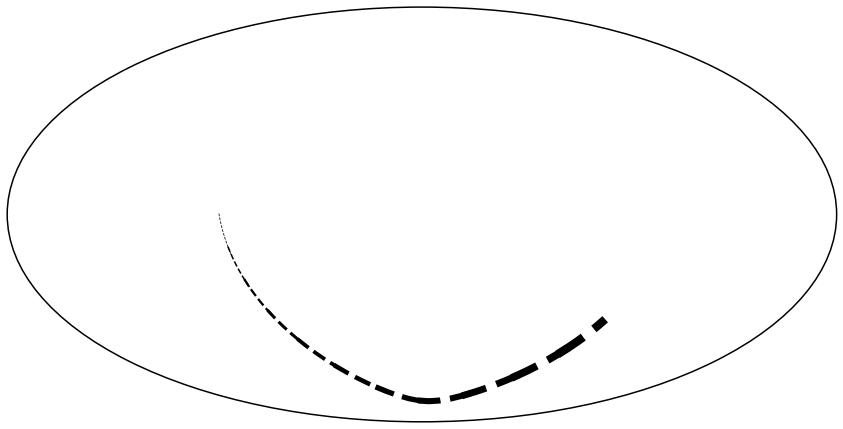

In [37]:
fig = plt.figure(figsize=(12,6))
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="mollweide")

ax = fig.add_axes([0.0,0.02,1.,.96], projection="hammer")



# third layer: trajectory and posteriors
#for indx in range(0,lvals.size-5,4): ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='white',linestyle='dashed',lw=indx*0.19,zorder=92)
for indx in range(0,lvals.size-5,4): ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='black',linestyle='dashed',lw=indx*0.19,zorder=92)


ax.set_xticklabels(())
ax.set_yticklabels(())
ax.grid(False,alpha=0.0,zorder=10)

ax.set_xticklabels(());ax.set_yticklabels(())


plt.savefig('figures/figure1c_onlytraj_black.png',dpi=400,transparent=True)




/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/2816580073.py:27: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False,alpha=0.0,zorder=10)


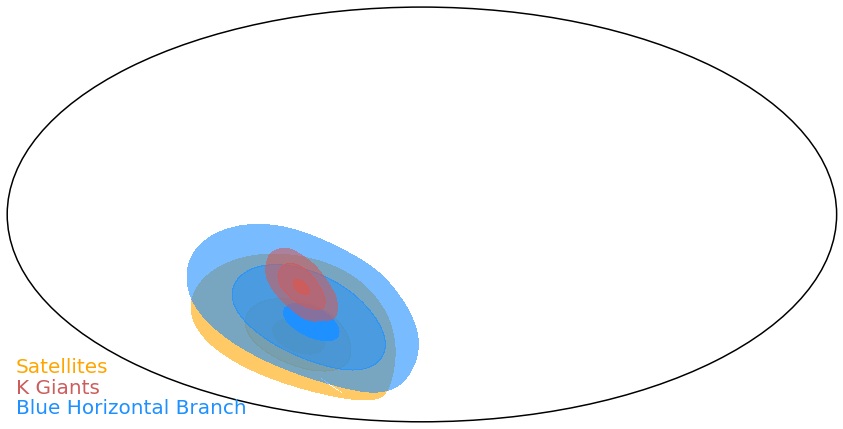

In [17]:
fig = plt.figure(figsize=(12,6))
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="mollweide")

ax = fig.add_axes([0.0,0.02,1.,.96], projection="hammer")



dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']
colorlist = ['salmon','orange','salmon','cyan']


posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)

ax.text(0.03, 0.098+0.048, 'Satellites', color=satcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
ax.text(0.03, 0.098, 'K Giants', color=kcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
ax.text(0.03, 0.05, 'Blue Horizontal Branch', color=bhbcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')


ax.set_xticklabels(())
ax.set_yticklabels(())
ax.grid(False,alpha=0.0,zorder=10)

ax.set_xticklabels(());ax.set_yticklabels(())


plt.savefig('figures/figure1c_onlyposteriors.png',dpi=400,transparent=True)





[0.         0.03056707 0.06113413 0.0917012  0.12226827 0.15283533
 0.1834024  0.21396946 0.24453653 0.2751036  0.30567066 0.33623773
 0.3668048  0.39737186 0.42793893 0.458506   0.48907306 0.51964013
 0.5502072  0.58077426 0.61134133 0.64190839 0.67247546 0.70304253
 0.73360959 0.76417666 0.79474373 0.82531079 0.85587786 0.88644493
 0.91701199 0.94757906 0.97814613 1.00871319 1.03928026 1.06984732
 1.10041439 1.13098146 1.16154852 1.19211559 1.22268266 1.25324972
 1.28381679 1.31438386 1.34495092 1.37551799 1.40608506 1.43665212
 1.46721919 1.49778625 1.52835332 1.55892039 1.58948745 1.62005452
 1.65062159 1.68118865 1.71175572 1.74232279 1.77288985 1.80345692
 1.83402398 1.86459105 1.89515812 1.92572518 1.95629225 1.98685932
 2.01742638 2.04799345 2.07856052 2.10912758 2.13969465 2.17026172]


/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/1361383451.py:24: RuntimeWarning: divide by zero encountered in log10
  imgf = np.log10(img.T.reshape(-1,))
/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/1361383451.py:93: UserWarning: First parameter to grid() is false, but line properties are supplied. The grid will be enabled.
  ax.grid(False,alpha=0.0,zorder=10)


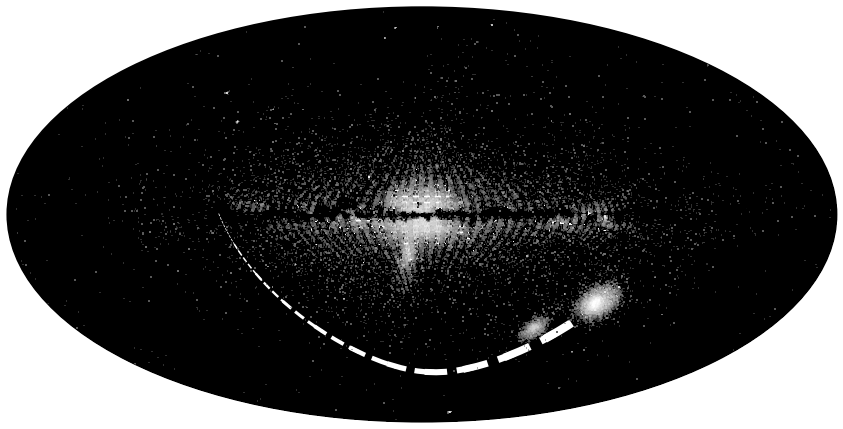

In [20]:
# now construct Figure 1: multiple layers
#


kcolor = 'tomato'


fig = plt.figure(figsize=(12,6))
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")
#ax = fig.add_axes([0.0,0.02,1.,.96], projection="mollweide")

ax = fig.add_axes([0.0,0.02,1.,.96], projection="hammer")



crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)
#crange = np.linspace(np.nanpercentile(imgf,99.),np.nanpercentile(imgf,100.),72)



print(crange)

LL,BB = np.meshgrid(lbins,bbins)
imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]
LLf = LL.reshape(-1,)[~np.isfinite(imgf)]
BBf = BB.reshape(-1,)[~np.isfinite(imgf)]
ax.scatter(-LLf*np.pi/180.,
           BBf*np.pi/180.,
           color='black',s=1.,marker='s')

# define the transition between second and fourth layers
colorcut = 2.0
colorcut = 0.0

# second layer: dark points
incbrightness = 0.15
#incbrightness = 0.25
cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]
LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
smlrg = np.argsort(cvals[cvals<=colorcut])
ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals<=colorcut][smlrg],1.),s=0.13,marker='s')


# third layer: trajectory and posteriors
for indx in range(0,lvals.size-5,4): ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='white',linestyle='dashed',lw=indx*0.19,zorder=92)



dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']
colorlist = ['salmon','orange','salmon','cyan']




#posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

#posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

#posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)


# fourth layer: bright stellar points
cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
smlrg = np.argsort(cvals[cvals>colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals>colorcut][smlrg]+incbrightness,1.),s=0.13,marker='s',zorder=100)



ax.set_xticklabels(())
ax.set_yticklabels(())

#ax.text(0.01, 0.098+0.048, 'Satellites', color=satcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
#ax.text(0.01, 0.098, 'K Giants', color=kcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')
#ax.text(0.01, 0.05, 'Blue Horizontal Branch', color=bhbcolor, transform=fig.transFigure,fontsize=20,va='center',ha='left')


#ax.text((np.pi/180.)*80.,(np.pi/180.)*-22.,'LMC',color='white',size=22,ha='center',va='center')

#ax.grid(True,alpha=0.5,zorder=10)
ax.grid(False,alpha=0.0,zorder=10)

ax.set_xticklabels(());ax.set_yticklabels(())


plt.savefig('figures/figure1c_withtraj.png',dpi=400)


/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/1011556035.py:11: RuntimeWarning: divide by zero encountered in log10
  imgf = np.log10(img.T.reshape(-1,))


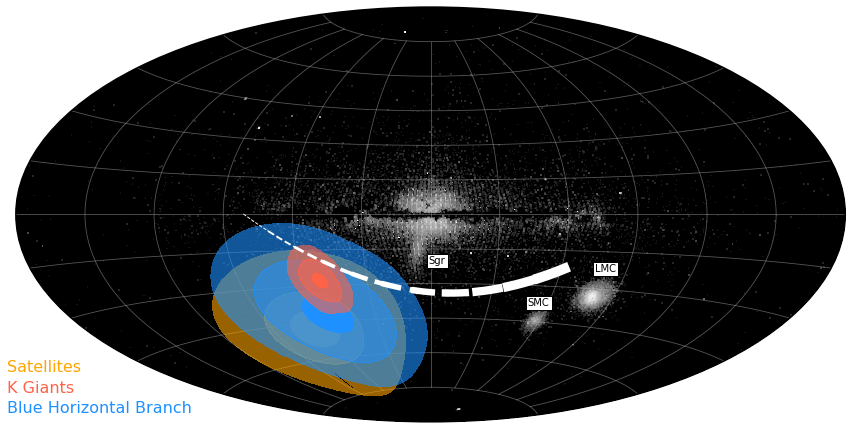

In [27]:

fig = plt.figure(figsize=(12,6))
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)



LL,BB = np.meshgrid(lbins,bbins)

imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]

LLf = LL.reshape(-1,)[~np.isfinite(imgf)]
BBf = BB.reshape(-1,)[~np.isfinite(imgf)]

ax.scatter(-LLf*np.pi/180.,
           BBf*np.pi/180.,
           color='black',s=1.,marker='s')

# define the transition between second and fourth layers
colorcut = 2.0

# second layer: dark points
incbrightness = 0.15


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
smlrg = np.argsort(cvals[cvals<=colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals<=colorcut][smlrg],1.),s=0.13,marker='s')






# third layer: trajectory and posteriors
for indx in range(0,lvals.size-4,4):
    ax.plot(lvals[indx:indx+6],bvals[indx:indx+6],color='white',linestyle='dashed',lw=indx*0.23,zorder=92)



dictnames = [BHB,KGiants,SAT,ALL]
colorlist = ['blue','red','cyan','black']
colorlist = ['salmon','orange','salmon','cyan']

posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(KGiants['phi']),(np.pi/180.)*KGiants['theta'],kcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=90)

posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(SAT['phi']),(np.pi/180.)*SAT['theta'],satcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=100,binset=[92.,98.,99.5],zorder=88)

posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*(BHB['phi']),(np.pi/180.)*BHB['theta'],bhbcolor,border=False,bounds=[-1,-1,-1,-1],gridsize=120,binset=[90.,96.,99.5],zorder=89)

#allcolor='silver'
#plot_aitoff_banana(ax,-(np.pi/180.)*ALL['phi'],(np.pi/180.)*ALL['theta'],allcolor,border=True,bounds=[-1,-1,-1,-1],gridsize=120,binset=[92.,98.,99.5],zorder=91)



# fourth layer: bright stellar points


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
smlrg = np.argsort(cvals[cvals>colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals>colorcut][smlrg]+incbrightness,1.),s=0.13,marker='s',zorder=100)



ax.grid(True,alpha=0.5)
ax.set_xticklabels(())
ax.set_yticklabels(())

ax.text(0.01, 0.098+0.048, 'Satellites', color=satcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
#ax.text(0.01,0.098+0.048, 'Combined stars', color=allcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
ax.text(0.01, 0.098, 'K Giants', color=kcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')
ax.text(0.01, 0.05, 'Blue Horizontal Branch', color=bhbcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')





ax.text((np.pi/180.)*80.,(np.pi/180.)*-22.,'LMC',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
ax.text((np.pi/180.)*55.,(np.pi/180.)*-37.,'SMC',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
ax.text((np.pi/180.)*3.,(np.pi/180.)*-20.,'Sgr',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))






ax.grid(True,alpha=0.5,zorder=10)
ax.set_xticklabels(())
ax.set_yticklabels(())


plt.savefig('figures/draftfigure1_noall.png',dpi=400)








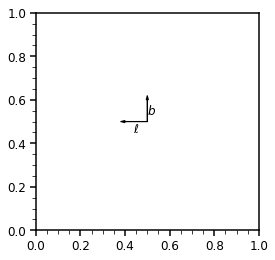

In [15]:
# make a nice arrow for later placing on the figure.

plt.figure(figsize=(4,4))

plt.arrow(0.5,0.5,-0.1,0.0,head_width=0.01, head_length=0.02)
plt.arrow(0.5,0.5,0.0,0.1,head_width=0.01, head_length=0.02)
plt.text(0.45,0.465,'$\ell$',size=12,ha='center',va='center')
plt.text(0.52,0.55,'$b$',size=12,ha='center',va='center')


plt.savefig('figures/arrow.png',dpi=400)

/var/folders/6w/dlp9742d17v7x08hrlbn3d0r0000gn/T/ipykernel_80150/1337454635.py:11: RuntimeWarning: divide by zero encountered in log10
  imgf = np.log10(img.T.reshape(-1,))


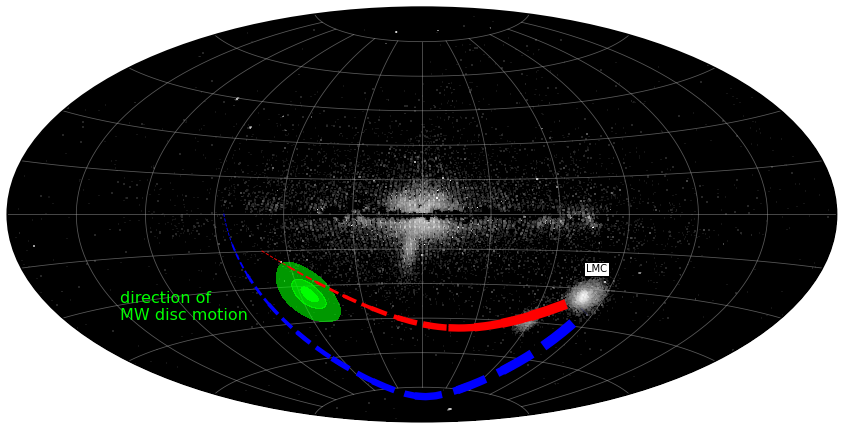

In [46]:

fig = plt.figure(figsize=(12,6),facecolor='white')
ax = fig.add_axes([0.0,0.02,1.,.96], projection="aitoff")


crange = np.linspace(np.nanpercentile(imgf,91.),np.nanpercentile(imgf,100.),72)



LL,BB = np.meshgrid(lbins,bbins)

imgf = np.log10(img.T.reshape(-1,))

# first layer: background black points
cvals = (imgf/np.nanmax(crange))[~np.isfinite(imgf)]

LLf = LL.reshape(-1,)[~np.isfinite(imgf)]
BBf = BB.reshape(-1,)[~np.isfinite(imgf)]

ax.scatter(-LLf*np.pi/180.,
           BBf*np.pi/180.,
           color='black',s=1.,marker='s')

# define the transition between second and fourth layers
colorcut = 2.0

# second layer: dark points
incbrightness = 0.15


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals<=colorcut]
smlrg = np.argsort(cvals[cvals<=colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals<=colorcut][smlrg],1.),s=0.13,marker='s')






# third layer: trajectory and posteriors
for indx in range(0,lvals.size-4,4):
    ax.plot(lvals2[indx:indx+6]+(np.pi/180.)*10.,bvals2[indx:indx+6]-(np.pi/180.)*15.,color='red',linestyle='dashed',lw=indx*0.23,zorder=92)
    ax.plot(lvals[indx:indx+6]-(np.pi/180.)*5.,bvals[indx:indx+6],color='blue',linestyle='dashed',lw=indx*0.23,zorder=92)




allcolor='lime'
posteriorreader.plot_aitoff_banana(ax,-(np.pi/180.)*ALL['phi'],(np.pi/180.)*ALL['theta'],allcolor,border=True,bounds=[-1,-1,-1,-1],gridsize=120,binset=[92.,98.,99.5],zorder=91)



# fourth layer: bright stellar points


cvals = (imgf/np.nanmax(crange))[np.isfinite(imgf)]

LLf = LL.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
BBf = BB.reshape(-1,)[np.isfinite(imgf)][cvals>colorcut]
smlrg = np.argsort(cvals[cvals>colorcut])

ax.scatter(-LLf[smlrg]*np.pi/180.,
           BBf[smlrg]*np.pi/180.,
           color=cm.Greys_r(cvals[cvals>colorcut][smlrg]+incbrightness,1.),s=0.13,marker='s',zorder=100)



ax.grid(True,alpha=0.5)
ax.set_xticklabels(())
ax.set_yticklabels(())

ax.text(0.15,0.238+0.048, 'direction of\nMW disc motion', color=allcolor, transform=fig.transFigure,fontsize=16,va='center',ha='left')





ax.text((np.pi/180.)*80.,(np.pi/180.)*-22.,'LMC',\
        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
#ax.text((np.pi/180.)*55.,(np.pi/180.)*-37.,'SMC',\
#        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))
#ax.text((np.pi/180.)*3.,(np.pi/180.)*-20.,'Sgr',\
#        color='black',size=10,ha='center',va='center',bbox=dict(facecolor='white', edgecolor='black',pad=2))






ax.grid(True,alpha=0.5,zorder=10)
ax.set_xticklabels(())
ax.set_yticklabels(())


plt.savefig('figures/draftfigure1_all2.png',dpi=400)







